# Baseline Model Fine-tuning Demo

In [62]:
# we will start with a quick example of fine-tuning a model. There's no expectation for this demo to make sense entirely yet. It's to give a high level understanding of the process of fine-tuning a model, the steps involved, and the general flow of the code. It also will serve as a baseline performance we can iterate on by selecting different models, different hyperparameters, and different data augmentation strategies. Different models will be explored in the "Models" section of this notebook, and different hyperparameters and data augmentation strategies will be explored in the "Hyperparameters" section of this notebook.

# The steps include:
# 1. Load in the data
# 2. Load the tokenizer
# 2. Load in the pre-trained model
# 3. Define an evaluation metric
# 4. Train the model
# 5. Evaluate the model

In [58]:
%%capture
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install torch
!pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [59]:
import numpy as np
import evaluate
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [60]:
# %%capture

# 1. Load in the data
dataset = load_from_disk("data/yelp_review_tiny/")

# 2. Load the tokenizer and define the tokenization function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 3. Tokenize our training and test data
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Load in the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# 5. Define an evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 6. Set up the Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 7. Train the model
trainer.train()

Loading cached processed dataset at /Users/d/repos/bert/data/yelp_review_tiny/train/cache-82a3bf31b6b0592c.arrow


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.6107069253921509, 'eval_accuracy': 0.2, 'eval_runtime': 1.5442, 'eval_samples_per_second': 12.952, 'eval_steps_per_second': 1.943, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.5988649129867554, 'eval_accuracy': 0.2, 'eval_runtime': 1.5265, 'eval_samples_per_second': 13.102, 'eval_steps_per_second': 1.965, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.587171196937561, 'eval_accuracy': 0.25, 'eval_runtime': 1.5297, 'eval_samples_per_second': 13.074, 'eval_steps_per_second': 1.961, 'epoch': 3.0}
{'train_runtime': 93.2984, 'train_samples_per_second': 3.215, 'train_steps_per_second': 0.418, 'train_loss': 1.6029120225172777, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=1.6029120225172777, metrics={'train_runtime': 93.2984, 'train_samples_per_second': 3.215, 'train_steps_per_second': 0.418, 'train_loss': 1.6029120225172777, 'epoch': 3.0})

In [45]:
model.to('cpu')

def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id

review_5stars = "This is a great restaurant!"
review_4stars = "This was overall a good experience, above average restaurant"
review_3stars = "This was an alright restaurant"
review_2stars = "This is a pretty bad restaurant. I might try again but I was disappointed"
review_1stars = "This is a terrible restaurant!"

reviews = [review_5stars, review_4stars, review_3stars, review_2stars, review_1stars]

for review in reviews:
    print(f"Model predicted {predict(review)+1} stars for review: {review}")

Model predicted 5 stars for review: This is a great restaurant!
Model predicted 4 stars for review: This was overall a good experience, above average restaurant
Model predicted 4 stars for review: This was an alright restaurant
Model predicted 2 stars for review: This is a pretty bad restaurant. I might try again but I was disappointed
Model predicted 5 stars for review: This is a terrible restaurant!


## Don't run this!! But see that simply adding more data, same code, the accuracy improves

In [18]:
# %%capture

# 1. Load in the data
dataset = load_from_disk("data/yelp_review_small/")

# 2. Load the tokenizer and define the tokenization function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 3. Tokenize our training and test data
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Load in the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# 5. Define an evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 6. Set up the Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 7. Train the model
trainer.train()

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

/Users/d/miniforge3/envs/bert/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0930134057998657, 'eval_accuracy': 0.525, 'eval_runtime': 15.3889, 'eval_samples_per_second': 12.996, 'eval_steps_per_second': 1.625, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0063376426696777, 'eval_accuracy': 0.58, 'eval_runtime': 15.3839, 'eval_samples_per_second': 13.001, 'eval_steps_per_second': 1.625, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.015762448310852, 'eval_accuracy': 0.595, 'eval_runtime': 15.3847, 'eval_samples_per_second': 13.0, 'eval_steps_per_second': 1.625, 'epoch': 3.0}
{'train_runtime': 745.9547, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.402, 'train_loss': 0.9802055867513021, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.9802055867513021, metrics={'train_runtime': 745.9547, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.402, 'train_loss': 0.9802055867513021, 'epoch': 3.0})

In [42]:
model.to('cpu')

def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id

review_5stars = "This is a great restaurant!"
review_4stars = "This was overall a good experience, above average restaurant"
review_3stars = "This was an alright restaurant"
review_2stars = "This is a pretty bad restaurant. I might try again but I was disappointed"
review_1stars = "This is a terrible restaurant!"

reviews = [review_5stars, review_4stars, review_3stars, review_2stars, review_1stars]

for review in reviews:
    print(f"Model predicted class {predict(review)} for review: {review}")

Model predicted class 4 for review: This is a great restaurant!
Model predicted class 3 for review: This was overall a good experience, above average restaurant
Model predicted class 2 for review: This was an alright restaurant
Model predicted class 1 for review: This is a pretty bad restaurant. I might try again but I was disappointed
Model predicted class 0 for review: This is a terrible restaurant!


# Models 

## bert-based-uncased

[See the model card for more information on the huggingface hub](https://huggingface.co/bert-base-uncased)

[Google's release on github and associated bert models](https://github.com/google-research/bert/blob/master/README.md) 

In [5]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Masked Language Modeling

Here you can play with one of the "dummy tasks" BERT learned from. Let's pretend to be BERT learning a language and try to guess the masked word in the following sentence.

In [6]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
%%capture  # comment out this line to see the results of the model
text = "She craved [MASK] to quench her thirst."
unmasker(text)

UsageError: unrecognized arguments: comment out this line to see the results of the model


In [56]:
%%capture # comment out this line to see the results of the model
text = "The best thing about [MASK] is they mostly clean up after themselves!"
unmasker(text)

UsageError: unrecognized arguments: comment out this line to see the results of the model


Ok, those are very interesting guesses...  It certainly begs the question, what data was this model trained on? In the next section on Datasets, we will take a look. 

But for now, let's take a moment to create new masked sentences and see if we can derive any other interesting insights into how this model "models" language. See if you can come up with any surprising results!

Suggestions:
- Try some sentences with references to your culture, holidays, food, etc.
- Try some sentences about historical events or people
- Try some sentences about scientific discoveries or any field of interest to you
- Try making up a joke, a song lyric or a short poem

In [57]:
%%capture # comment out this line to see the results of the model
# Create a prompt text with some words masked out, see what the model predicts
text = "Give the model a [MASK] to predict."
unmasker(text)

UsageError: unrecognized arguments: comment out this line to see the results of the model


To answer that question, what data was this model trained on? [Let's take a look at the model card on Hugging Face](https://huggingface.co/bert-base-uncased?text=The+goal+of+life+is+%5BMASK%5D.)

After inspecting the model card for "bert-base-uncased" on the hugging face hub, we found that "The BERT model was pretrained on BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers)."

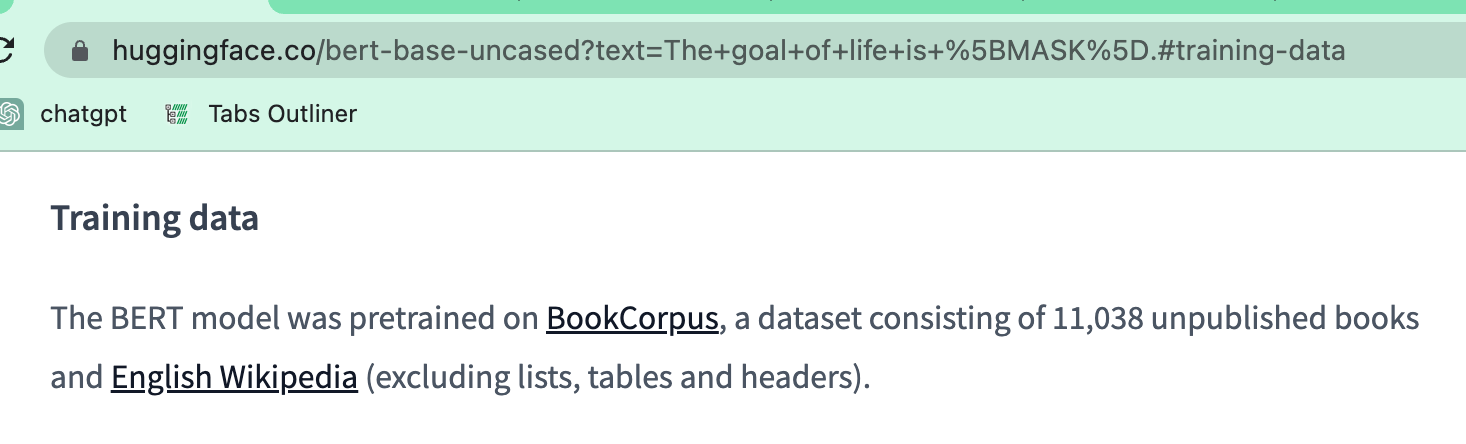

# Datasets

## BookCorpus


[Let's now take a look on the hugging face hub of the dataset card for BookCorpus](https://huggingface.co/datasets/bookcorpus)  

We noticed the dataset as already been preprocessed and doesn't include metadata, as to where the data came from. 

We found the homepage for the original authors of BERT: https://yknzhu.wixsite.com/mbweb

But it looks like they aren't hosting the original dataset anymore. 

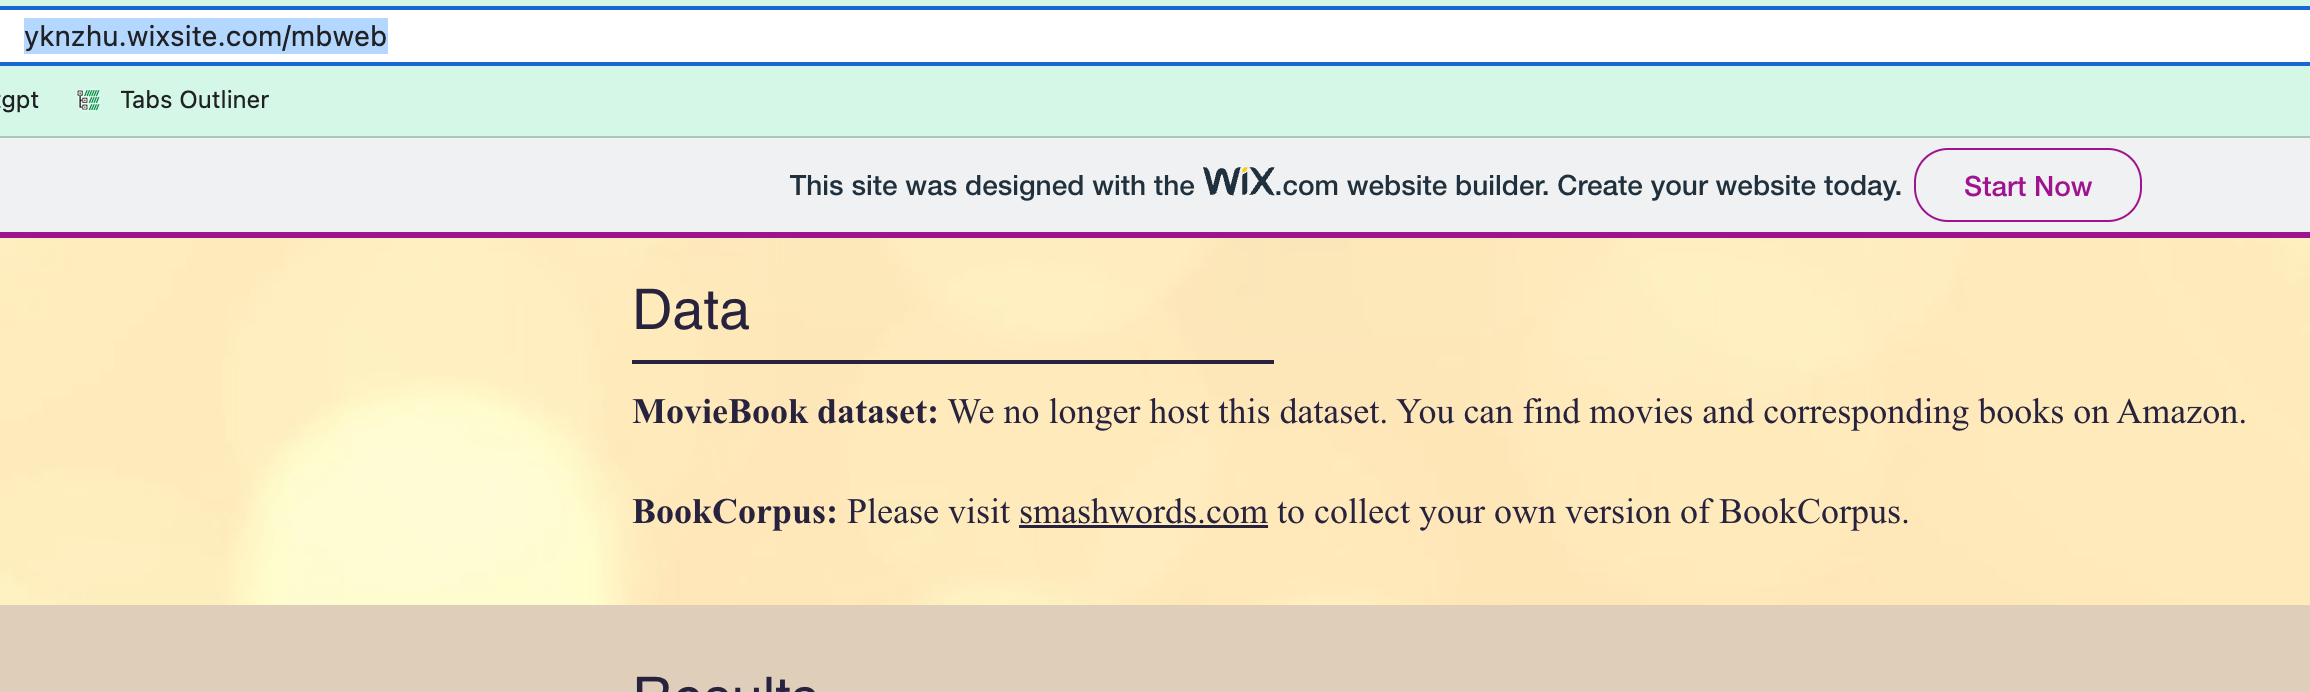  

So we looked a little deeper down the page of the dataset card, and we found a link to a paper [Addressing Documentation Debt" in Machine Learning Research: A Retrospective Datasheet for BookCorpus](https://arxiv.org/pdf/2105.05241.pdf)  

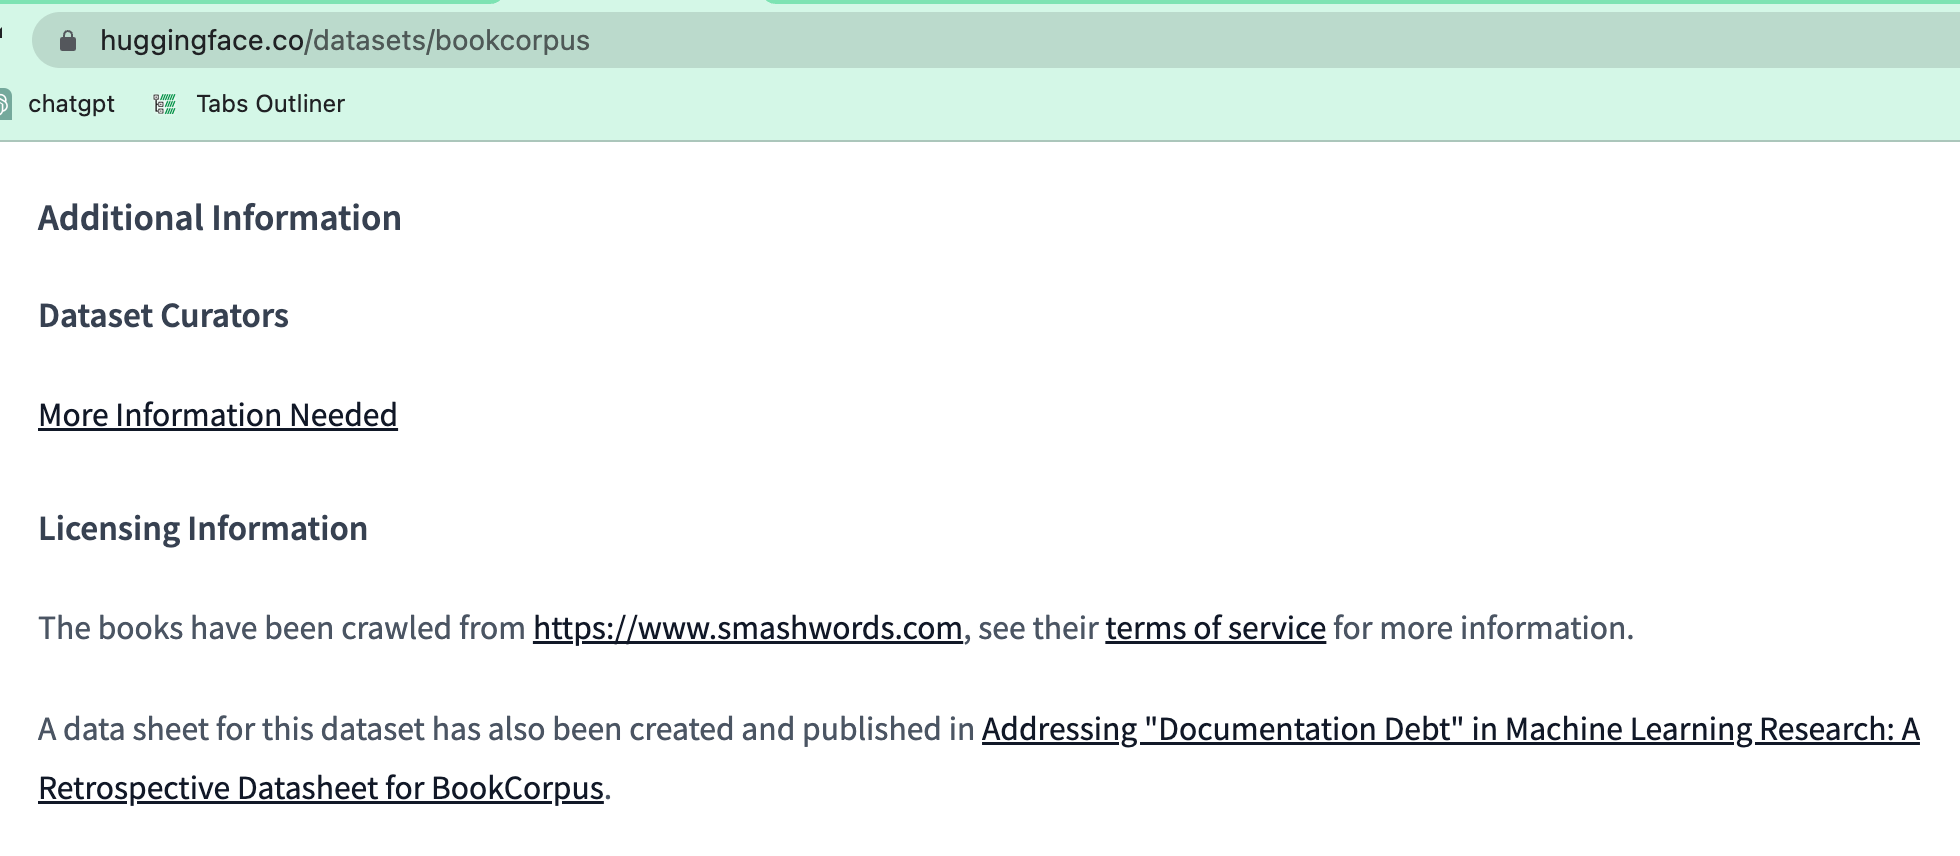  

And WOW! Lot's of interesting information here...

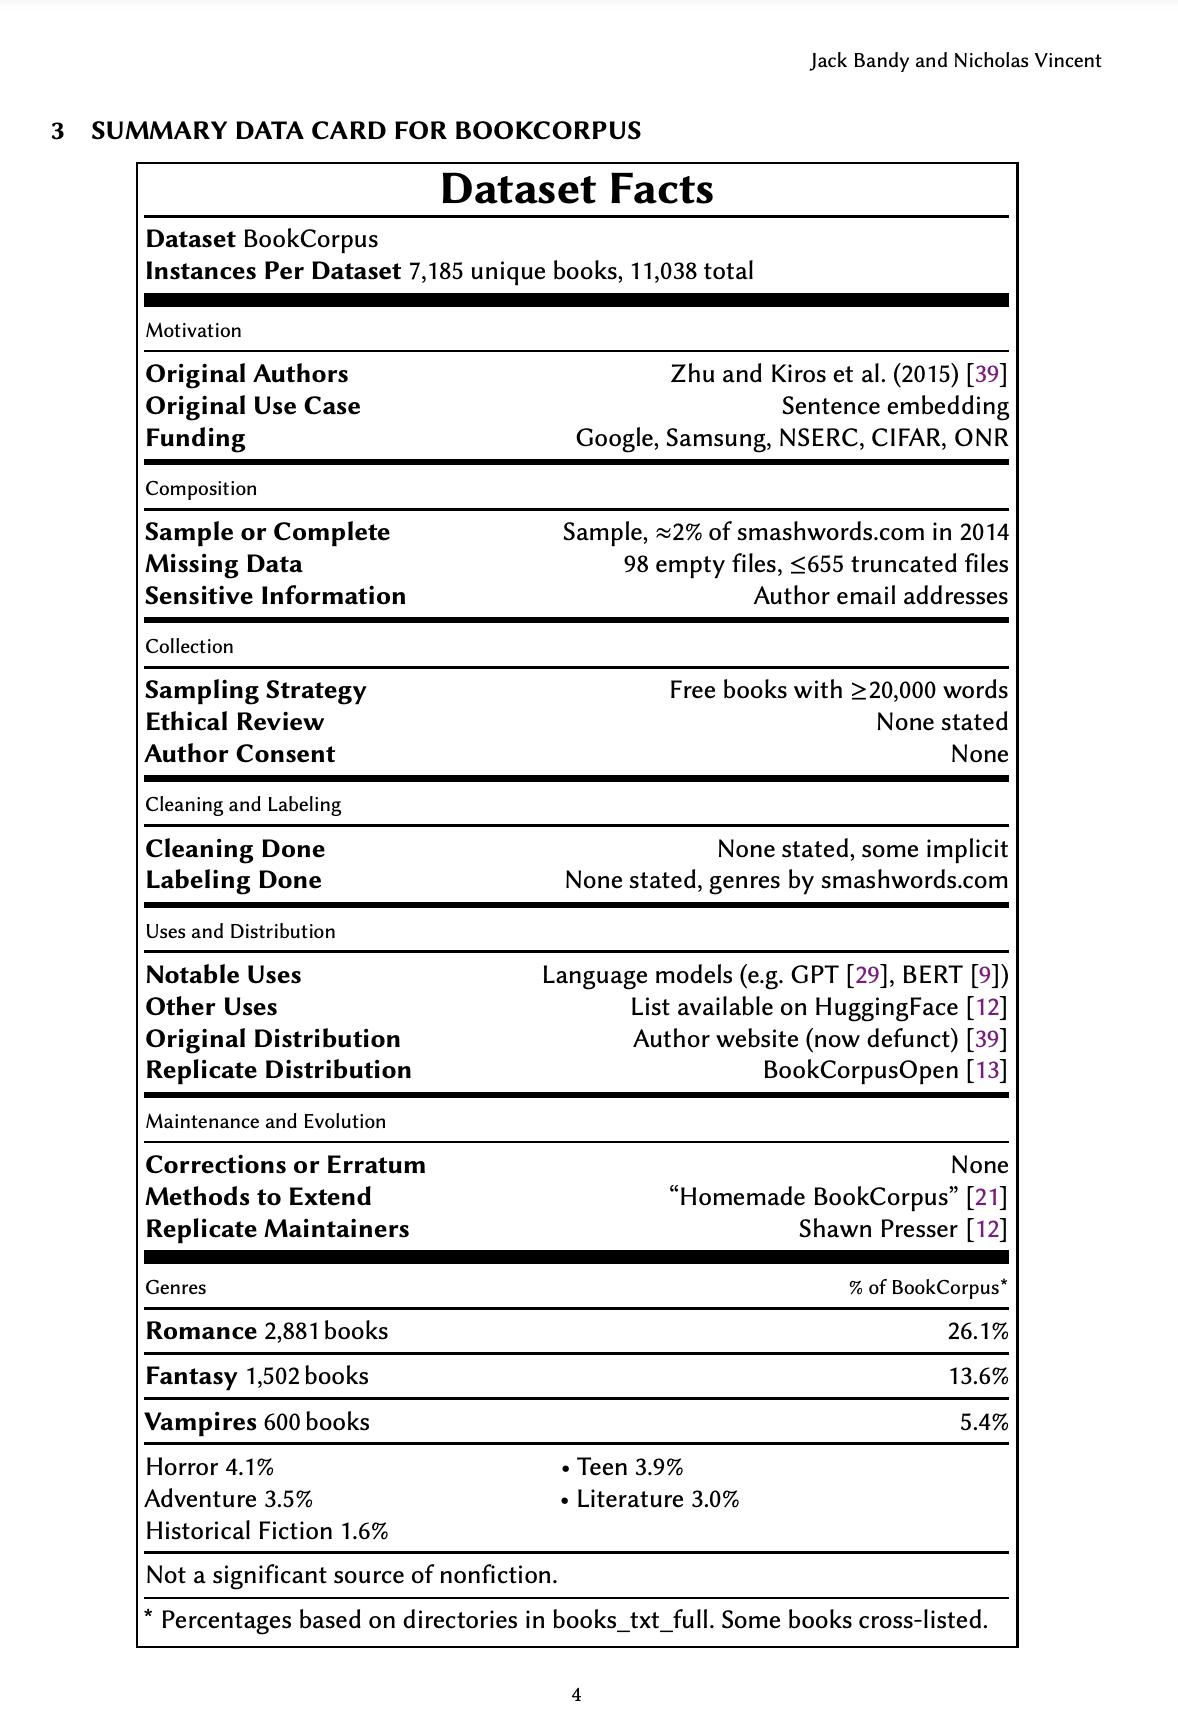  

This might explain why BERT thought blood, not gatorade might quench her thirst in our example above:

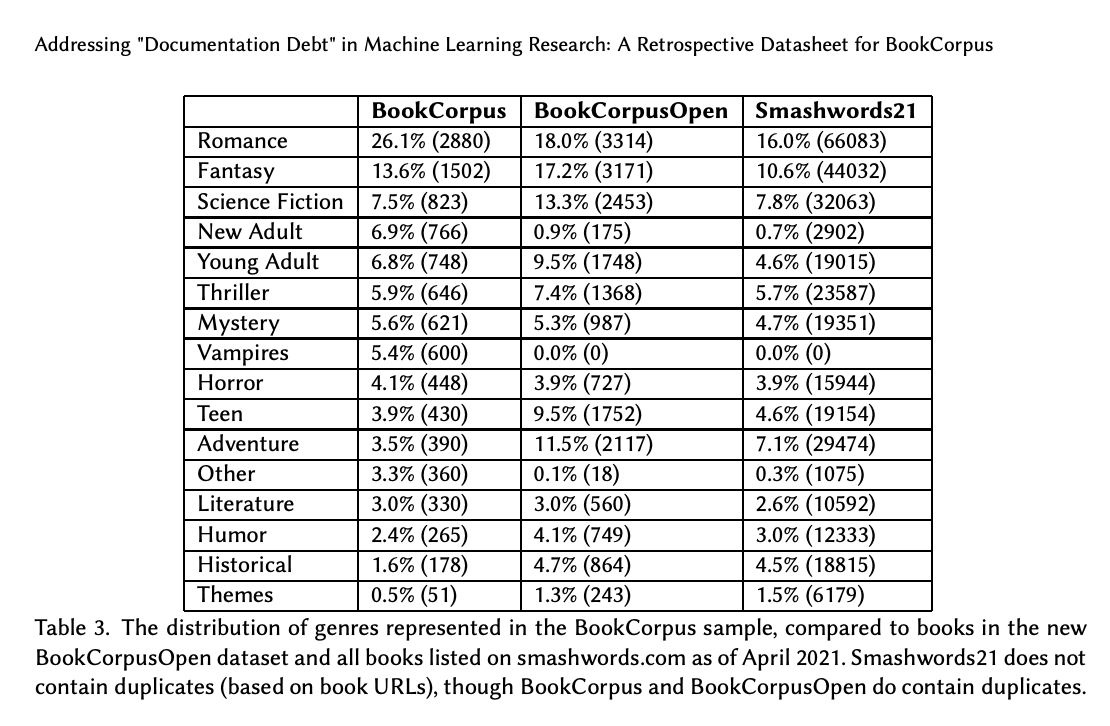  

Among other concerning things in this write-up, there are a number of books in this corpus that have stated copyrights:  

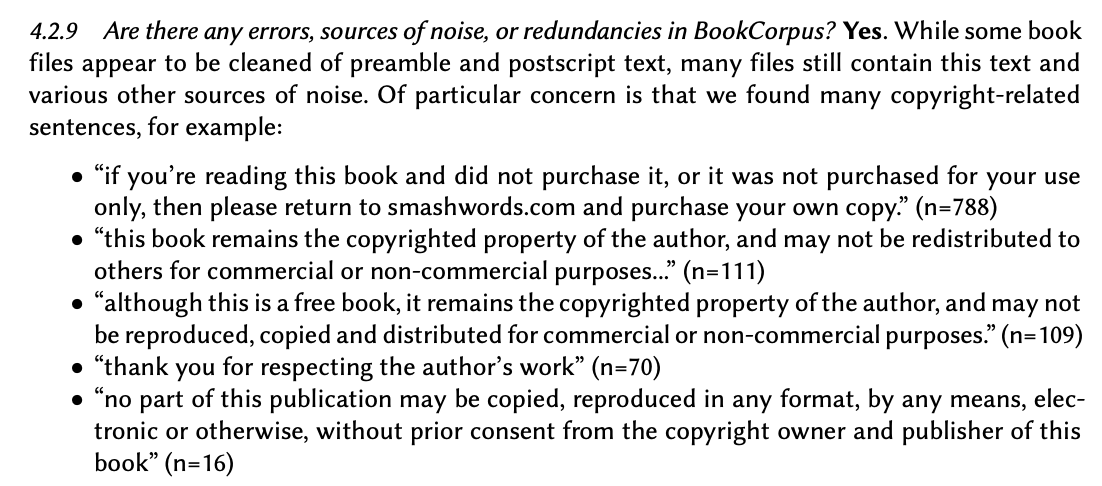

## BookCorpusOpen (Don't run these! It will take a long time)

In [11]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("bookcorpusopen")

Found cached dataset bookcorpusopen (/Users/d/.cache/huggingface/datasets/bookcorpusopen/plain_text/1.0.0/98559c92eb612e150a676c5b5131f9f8f07d4cab88e7f3761fda266ad22ff2a7)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
df = pd.DataFrame(dataset["train"])

In [44]:
import re

def get_email_addresses(text):
    return re.findall('[0-9a-zA-z]+@[0-9a-zA-z]+\.[0-9a-zA-z]+', text)

def get_copyright(text):
    return re.findall('Copyright\s*\d*', text)

def get_license_notes(text):
    return re.findall('License Notes\n\n(.*?)(?:\n)', text)


In [14]:
df["email_addresses"] = df["text"].apply(get_email_addresses)
df["copyright"] = df["text"].apply(get_copyright)
df["license_notes"] = df["text"].apply(get_license_notes)

In [15]:
# df filtered where email_addresses is not empty, license_notes is not empty, and copy right is not empty
df_notgood = df[(df["email_addresses"].str.len() > 0) & (df["license_notes"].str.len() > 0) & (df["copyright"].str.len() > 0)]

In [16]:
df_notgood.head()

,title,text,email_addresses,copyright,license_notes
5,satan-the-sworn-enemy-of-mankind.epub.txt,\n## SATAN:\n\n## The Sworn Enemy of Mankind...,[info@harunyahya.com],[Copyright ],[## All rights reserved. No part of this publi...
12,crown-of-thorns-the-race-to-clone-jesus-christ...,\n### Crown of Thorns -\n\n### The Race To Cl...,"[iancpirvine@hotmail.co, iancpirvine@hotmail.co]",[Copyright 2001],[This book is licensed for your personal enjoy...
27,shattered.epub.txt,\n\nSHATTERED\n\nby\n\nSandra Madera\n\nEdited...,[smadera23@yahoo.com],[Copyright ],[This ebook is licensed for your personal enjo...
33,a-course-in-miracles-wth-comments-by-ron-rasmu...,\n\n### A Course in Miracles with Comments\n\n...,"[ARequiredCourse@yahoogroups.com, Rasmussen@ao...",[Copyright 2015],[This ebook is licensed for your personal enjo...
60,red-warp.epub.txt,\nRed Warp\n\nDon DeBon\n\nStandard Edition\n\...,[debon@gmail.com],"[Copyright , Copyright ]",[This e-book is licensed for your personal enj...


In [54]:
# for note in df_notgood["license_notes"]:
#     print(note)

## Yelp

# Hyperparameter Tuning

There are a number of hyperparameters that can be tuned to improve the performance of the model. We will constrain the scope of what we cover to highlight some hyperparameters specific to the model architecture and the training process.

Hyperparameters specific to Model architecture include:
- "model_name": The name of the model architecture to use. This is the name of the model architecture as defined by the Hugging Face library. For example, "bert-base-uncased" is the name of the model architecture for the BERT model.
- "num_labels": The number of labels in the dataset. This is the number of classes in the dataset. For example, if the dataset is a binary classification dataset, then this number is 2. If the dataset is a multi-class classification dataset, then this number is the number of classes in the dataset.

Hyperparameters specific to the training process include:
- "max_seq_length": The maximum sequence length of the input text. This is the maximum number of tokens in the input text. If the input text has more tokens than this number, then the input text is truncated to this length. If the input text has less tokens than this number, then the input text is padded with the token [PAD] to this length.
- "learning_rate": The learning rate used for training.
- "num_epochs": The number of epochs used for training.

# Fine-tuning

## Change the objective
Maybe we really just want to train this model on yelp data to use on organic mentions of our company or product on reddit, facebook pages, etc. and to track a "Net Promoter Score" without making people fill out surveys. So we'll simplify the problem to consider 5 star reviewers a "Promoter", 4 stars "Passives", and 1-3 stars "detractors"

Net Promoter Score: https://www.hotjar.com/net-promoter-score/

In [80]:
import pandas as pd
from datasets import Dataset

In [65]:
# 1. Load in the data
dataset = load_from_disk("data/yelp_review_tiny/")

In [68]:
dataset["train"][0]

{'label': 1,
 'text': "On balance I liked Hula Modern Tiki and would return.  That being said, my experience with Sunday brunch at Hula was rather hit or miss.\\n\\nI debated between 3 and 4 stars in large part based on the service.  For a moment I considered giving them the benefit of the doubt because they were pretty busy and giving them the fourth star.  But service should be just as good when the restaurant is busy right?\\n\\nThen came the goo.\\n\\nI had French Toast with thick sliced bacon and maple syrup (according to the menu).  The French toast was very good.  The bacon didn't arrive and I had to ask for it - when it arrived it was good, no big deal.  The big deal to me was that the menu said MAPLE SYRUP.  The French Toast did not come with MAPLE SYRUP.  It came with some gooey, thick, out of the bottle syrup.  I'm sorry but maple FLAVORED syrup is not MAPLE SYRUP or anything like it.  FAIL.  I would not have ordered the French Toast if I knew it was being served with corn s

In [69]:
dataset["train"][-1]

{'label': 0,
 'text': "Avoid this place... seriously.  I took my bong in for a pretty simple repair and what I got back was a Frankenstiened bong.  They sent my German Roor 3 footer to Blue Dot and what i got back was a butchered bong.  They cut my bong off at the ice catcher and reattached a wobbly based piece of crap! It went from being one of the Original Roors from Germany to a half american piece of crap that wont sit still.  When i first got it back i contacted Son at the shop and he said that Blue Dot was doing shows for Hemp Con and asked if i could wait a month to get it repaired properly, I agreed to wait and when i called back several times i was told they would no longer fix it and they offered me some crappy bong cleaner... really?!?!?!?! you took my great bong and turned it into a 3 foot piece of crap! Thanks you for F'ing up my bong you bunch of douches! Ted your a piece of crap for F@cking up my piece and hiding behind your disclaimer.  FU and your sh!tty shop! Your bus

In [73]:
# convert dataset to pandas dataframe
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# convert the train and test datasets into one pandas dataframe
df = pd.concat([df_train, df_test])

In [91]:
# convert the pandas dataframe into a dataset
dataset_2 = Dataset.from_pandas(df, preserve_index=False)

In [92]:
dataset_2

Dataset({
    features: ['label', 'text'],
    num_rows: 120
})

In [93]:
# create a new dataset with 100 training samples and 100 test samples
# stratify by column: ensures that the train and test sets have the same proportion of each class as the full dataset
dataset_3 = dataset_2["train"].train_test_split(train_size=100, test_size=20, seed=42, stratify_by_column="label")

KeyError: "Column train not in the dataset. Current columns in the dataset: ['label', 'text']"

In [90]:
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)


ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds

datasets.arrow_dataset.Dataset

In [83]:
help(Dataset.from_pandas)

Help on method from_pandas in module datasets.arrow_dataset:

from_pandas(df: pandas.core.frame.DataFrame, features: Optional[datasets.features.features.Features] = None, info: Optional[datasets.info.DatasetInfo] = None, split: Optional[datasets.splits.NamedSplit] = None, preserve_index: Optional[bool] = None) -> 'Dataset' method of builtins.type instance
    Convert `pandas.DataFrame` to a `pyarrow.Table` to create a [`Dataset`].
    
    The column types in the resulting Arrow Table are inferred from the dtypes of the `pandas.Series` in the
    DataFrame. In the case of non-object Series, the NumPy dtype is translated to its Arrow equivalent. In the
    case of `object`, we need to guess the datatype by looking at the Python objects in this Series.
    
    Be aware that Series of the `object` dtype don't carry enough information to always lead to a meaningful Arrow
    type. In the case that we cannot infer a type, e.g. because the DataFrame is of length 0 or the Series only
    con